<h3>Handwritten Digit Classification</h3>

<h4>Aim</h4>

Create a Convolutional Neural Network (CNN) with the aimed at recognizing MNIST handwritten digits. This entails the development of a CNN that can precisely identify grayscale images of digits 0 through 9, each sized at 28x28 pixels.

In each image , each pixel represents a feature. Therefore, a 256x256 image comprises 65,536 features, leading to a highly complex model. When such images are downsampled, a significant amount of detail is lost, resulting in data loss during model training. Moreover, the relationship between features is not simple; it's neither linear nor quadratic but is represented by varying brightness values.

This is where neural networks prove to be invaluable, as they can effectively manage and interpret this complexity and non-linearity in the data.

In [1]:
#import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
#from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from numpy import mean, std

<h4>Understanding the MNIST Dataset</h4>

#Load the dataset from mnist

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


<li>The Training set contains 60,000 small square 28×28 pixel images of handwritten digits.</li>
<li>While the Test setcontains 10,000 observations of digit classification ranging from 0 to 9.</li>

In [4]:
def prepare_dataset(train_images, train_labels, test_images, test_labels):
    """Prepare the MNIST dataset for CNN input."""
    # Reshape images to 28x28 pixels with a single channel
    train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
    test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))
    
    # One-hot encode labels
    num_classes = 10
    train_labels = to_categorical(train_labels, num_classes)
    test_labels = to_categorical(test_labels, num_classes)
    
    return train_images, train_labels, test_images, test_labels

In [5]:
train_images, train_labels, test_images, test_labels= prepare_dataset(train_images, train_labels, test_images, test_labels)

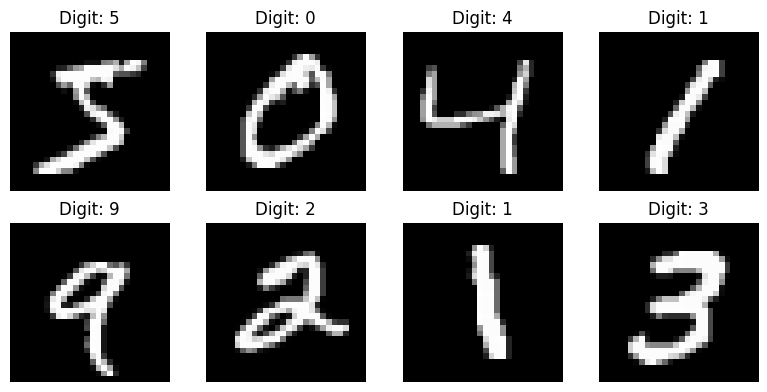

In [6]:
 # Visualize the first few images
num_rows, num_cols = 2, 4  # Define the layout of the plots
fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*2, num_rows*2))  # Define the figure size
for i in range(num_rows * num_cols):
    ax[i//num_cols, i%num_cols].imshow(train_images[i].squeeze(), cmap='gray')  # Squeeze to remove single-channel dimension for display
    ax[i//num_cols, i%num_cols].title.set_text("Digit: {}".format(np.argmax(train_labels[i])))
    ax[i//num_cols, i%num_cols].axis('off')
plt.tight_layout()
plt.show();

<h4> Preprocessing the Data</h4>

In [7]:
# Scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # Normalize pixel values to the range
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

<h4> Designing the CNN Architecture</h4>

In [8]:
# Define a function to create the CNN model structure.
def define_model():
    # Initialize a sequential model, so we can build the model layer by layer.
    model = Sequential()

    # Add the first convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation.
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))

    model.add(BatchNormalization()),

    # Add a max pooling layer with a 2x2 window to reduce the spatial dimensions of the output from the previous layer.
    model.add(MaxPooling2D((2, 2)))

    # Add the first convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation.
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform')),

    model.add(BatchNormalization()),

    model.add(MaxPooling2D((2, 2))),

    # Flatten the output from the pooling layer to a single vector to connect it with dense layers.
    model.add(Flatten())

    # Add a dense (fully connected) layer with 100 neurons and ReLU activation to interpret the features extracted by the convolutional layers.
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))

    # Add the output layer with 10 neurons (one for each class) using softmax activation to output probabilities for each class.
    model.add(Dense(10, activation='softmax'))

    # Compile the model, specifying the optimizer, loss function, and metrics to monitor.
    # Use Stochastic Gradient Descent (SGD) as the optimizer with a learning rate of 0.01 and momentum of 0.9.
    # Accuracy is used as the metric for performance evaluation.
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


<h4> Training the model </h4>

In [9]:
def evaluate_model(dataX, dataY, n_folds=5):
    """Evaluate the model using k-fold cross-validation."""
    scores, histories = [], []
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    for train_ix, test_ix in kfold.split(dataX):
        model = define_model()
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), 
                            callbacks=[early_stopping], verbose=0)
        
        _, acc = model.evaluate(testX, testY, verbose=0)
        print(f'> {acc:.3f}')
        
        scores.append(acc)
        histories.append(history)
    
    return scores, histories,model

<h4> Evaluating the model </h4>

In [10]:
def summarize_diagnostics(histories):
    """Plot diagnostic learning curves."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    
    for history in histories:
        ax1.plot(history.history['loss'], color='blue')
        ax1.plot(history.history['val_loss'], color='orange')
        ax2.plot(history.history['accuracy'], color='blue')
        ax2.plot(history.history['val_accuracy'], color='orange')
    
    ax1.set_title('Cross Entropy Loss')
    ax1.legend()
    ax2.set_title('Classification Accuracy')
    ax2.legend()
    plt.tight_layout()
    plt.show()

def summarize_performance(scores):
    """Summarize model performance."""
    print(f'Accuracy: mean={mean(scores):.3f} std={std(scores):.3f}, n={len(scores)}')
    plt.boxplot(scores)
    plt.show()

In [11]:
def plot_confusion_matrix(model, test_images, test_labels):
    """Compute and plot the confusion matrix."""
    y_pred = np.argmax(model.predict(test_images), axis=1)
    y_true = np.argmax(test_labels, axis=1)
    
    cm = tf.math.confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


In [12]:
def prediction(model, i):
    """Display an image from the test set and make a prediction."""
    if 1 <= i <= len(test_images):
        print('The input image is as below: \n')
        plt.matshow(test_images[i-1].reshape(28, 28), cmap='gray')
        plt.show()
        print('Model prediction is: \n', np.argmax(model.predict(test_images[i-1].reshape(1, 28, 28, 1))))
    else:
        print('Please input a number from 1 to', len(test_images))

In [13]:
def run_test_harness():
    """Run the test harness for evaluating the CNN model."""
    scores, histories, model = evaluate_model(train_images, train_labels)
    summarize_diagnostics(histories)
    model.save('final_model.h5')

    # Plot confusion matrix
    plot_confusion_matrix(model, test_images, test_labels)

    # Predict digit for a specific image index
    image_index = 42 
    prediction(model, image_index)

    # Calculate and print the mean accuracy
    mean_accuracy = np.mean(scores)
    print(f'Mean accuracy: {mean_accuracy:.3f}')


/Users/simone/Python_Projects/ML_challenge_bio_sciences/proteinsenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-03 10:06:10.513089: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-03 10:06:10.513163: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-03 10:06:10.513178: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-03 10:06:10.513508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-03 10:06:10.514049: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Create

> 0.990
> 0.991
> 0.987
> 0.993


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


> 0.988


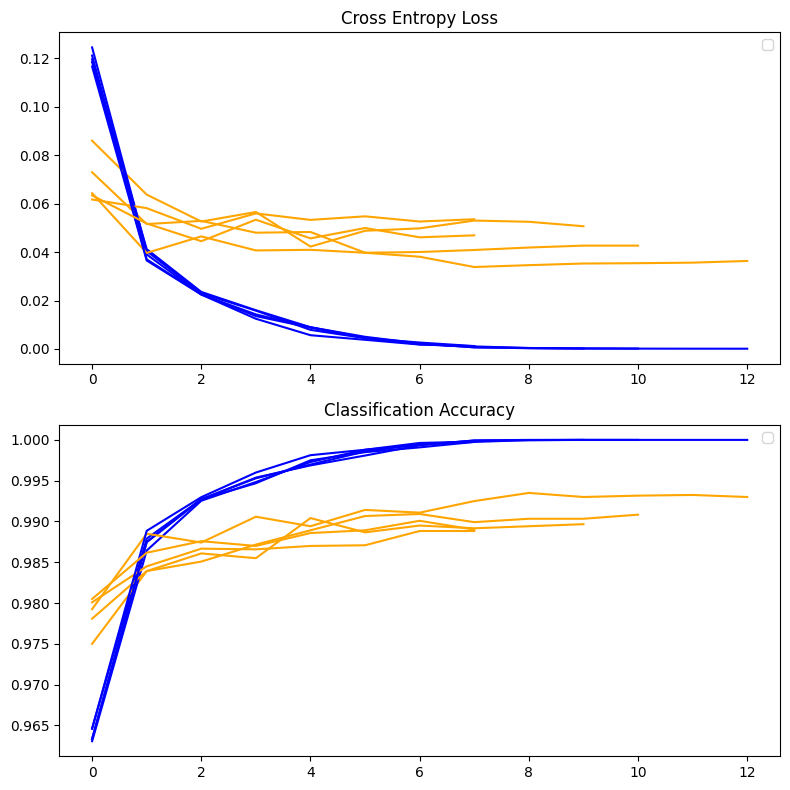

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


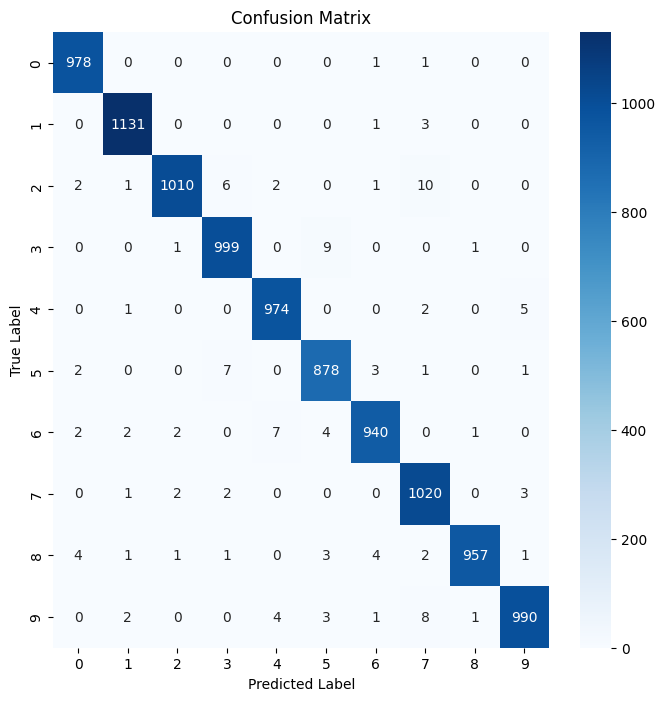

The input image is as below: 



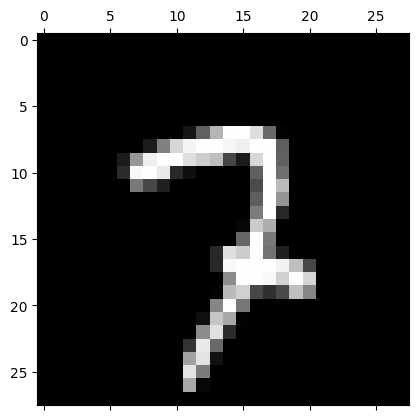

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Model prediction is: 
 7
Mean accuracy: 0.990


In [14]:
run_test_harness()